In [1]:
import pandas as pd  
import torch  
import torch.nn as nn  
import matplotlib.pyplot as plt  


Bad key text.latex.preview in file /home/frank/miniconda3/envs/condatest/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /home/frank/miniconda3/envs/condatest/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /home/frank/miniconda3/envs/condatest/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95    

In [2]:
# 读取数据  
df = pd.read_csv('stock.csv')  
  
# 将date列转换为日期类型  
df['date'] = pd.to_datetime(df['date'])  
  
# 排序数据  
df = df.sort_values('date')  
  
# 分割数据为训练集和测试集  
train_size = int(0.9 * len(df))  # 使用80%的数据作为训练集  
train_df = df[:train_size]  
test_df = df[train_size:]  

In [3]:
# 提取OLHC列作为特征  
train_features = train_df['OLHC'].values.reshape(-1, 1)  
test_features = test_df['OLHC'].values.reshape(-1, 1)  
  
# 归一化特征  
from sklearn.preprocessing import MinMaxScaler  
scaler = MinMaxScaler()  
train_features = scaler.fit_transform(train_features)  
test_features = scaler.transform(test_features)  
  
# 将特征转换为PyTorch张量  
train_features = torch.FloatTensor(train_features)  
test_features = torch.FloatTensor(test_features)  

In [4]:
class LSTMModel(nn.Module):  
    def __init__(self, input_size, hidden_size, output_size):  
        super(LSTMModel, self).__init__()  
        self.hidden_size = hidden_size  
        self.lstm = nn.LSTM(input_size, hidden_size)  
        self.fc = nn.Linear(hidden_size, output_size)  
  
    def forward(self, x):  
        h0 = torch.zeros(1, x.size(1), self.hidden_size)  
        c0 = torch.zeros(1, x.size(1), self.hidden_size)  
        out, _ = self.lstm(x, (h0, c0))  
        out = self.fc(out[-1])  
        return out  
  
# 设置模型参数  
input_size = 1  # 输入特征的维度  
hidden_size = 32  # LSTM隐藏层的大小  
output_size = 1  # 输出特征的维度  
  
# 创建模型实例  
model = LSTMModel(input_size, hidden_size, output_size)  

In [5]:
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

In [6]:
# 设置训练参数  
num_epochs = 100  
batch_size = 16  
  
# 创建数据加载器  
train_dataset = torch.utils.data.TensorDataset(train_features[:-1], train_features[1:])  
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  
  
# 开始训练  
model.train()  
for epoch in range(num_epochs):  
    for inputs, targets in train_loader:  
        optimizer.zero_grad()  
        outputs = model(inputs.unsqueeze(0))  
        loss = criterion(outputs, targets.unsqueeze(0))  
        loss.backward()  
        optimizer.step()  
    if (epoch+1) % 10 == 0:  
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item()}')  

/home/frank/miniconda3/envs/condatest/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 16, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/frank/miniconda3/envs/condatest/lib/python3.7/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 2, 1])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10/100, Loss: 0.0009943207260221243
Epoch: 20/100, Loss: 0.0019089188426733017
Epoch: 30/100, Loss: 0.00017476144421380013
Epoch: 40/100, Loss: 0.0007590701570734382
Epoch: 50/100, Loss: 0.00021365155407693237
Epoch: 60/100, Loss: 0.0006015122053213418
Epoch: 70/100, Loss: 0.0009444646420888603
Epoch: 80/100, Loss: 0.00019561457156669348
Epoch: 90/100, Loss: 0.0007852731505408883
Epoch: 100/100, Loss: 1.6318464986397885e-05


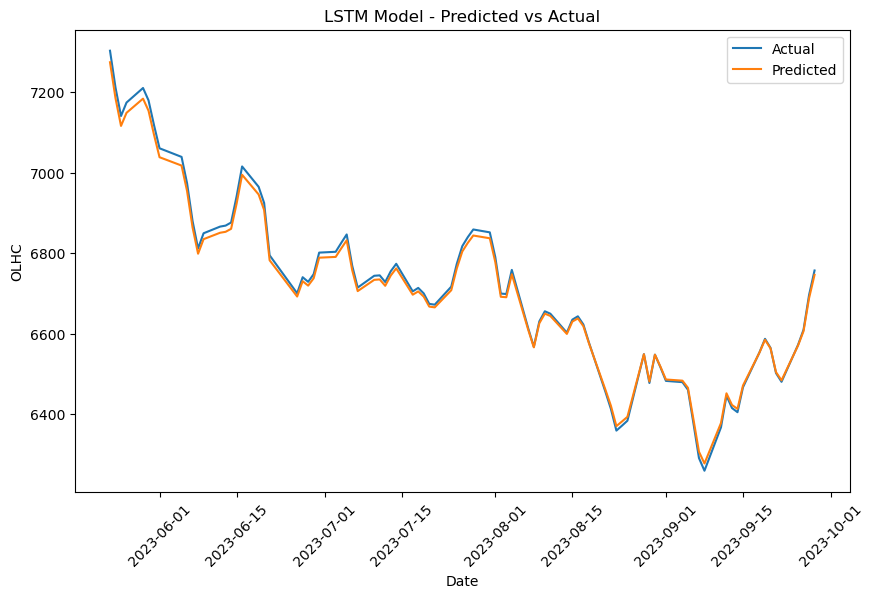

In [7]:
# 关闭梯度计算  
with torch.no_grad():  
    model.eval()  
    predicted = model(test_features.unsqueeze(0)).squeeze().numpy()  
  
# 反归一化预测结果  
predicted = scaler.inverse_transform(predicted.reshape(-1, 1))  
  
# 创建日期索引  
dates = test_df['date']  
  
# 绘制预测结果  
plt.figure(figsize=(10, 6))  
plt.plot(dates, test_df['OLHC'], label='Actual')  
plt.plot(dates, predicted, label='Predicted')  
plt.xlabel('Date')  
plt.ylabel('OLHC')  
plt.title('LSTM Model - Predicted vs Actual')  
plt.legend()  
plt.xticks(rotation=45)  
plt.show()  

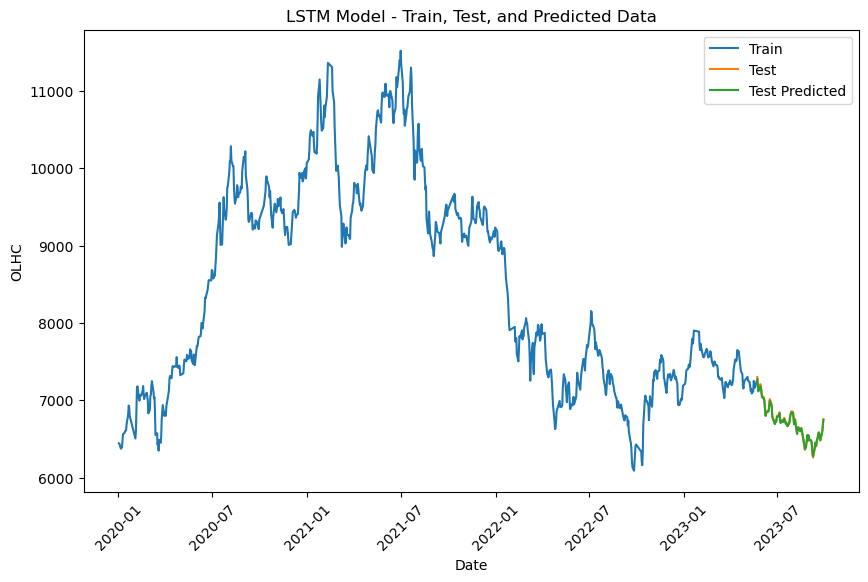

In [8]:
# 创建日期索引  
train_dates = train_df['date']  
test_dates = test_df['date']  
  
# 关闭梯度计算  
with torch.no_grad():  
    model.eval()  
    train_predicted = model(train_features.unsqueeze(0)).squeeze().numpy()  
    test_predicted = model(test_features.unsqueeze(0)).squeeze().numpy()  
  
# 反归一化预测结果  
train_predicted = scaler.inverse_transform(train_predicted.reshape(-1, 1))  
test_predicted = scaler.inverse_transform(test_predicted.reshape(-1, 1))  
  
# 绘制训练集、测试集和预测值的数据  
plt.figure(figsize=(10, 6))  
plt.plot(train_dates, train_df['OLHC'], label='Train')  
plt.plot(test_dates, test_df['OLHC'], label='Test')  
# plt.plot(train_dates, train_predicted, label='Train Predicted')  
plt.plot(test_dates, test_predicted, label='Test Predicted')  
plt.xlabel('Date')  
plt.ylabel('OLHC')  
plt.title('LSTM Model - Train, Test, and Predicted Data')  
plt.legend()  
plt.xticks(rotation=45)  
plt.show()  

In [9]:
from sklearn.metrics import mean_absolute_error 
  
# 计算训练集和测试集的预测值  
  
# 计算训练集和测试集的实际值  
train_actual = train_df['OLHC'].values  
test_actual = test_df['OLHC'].values  
  
# 计算MSE  
train_mae = mean_absolute_error(train_actual, train_predicted)  
test_mae = mean_absolute_error(test_actual, test_predicted)  
  
print("Train MSE:", train_mae)  
print("Test MSE:", test_mae)  

Train MSE: 28.559399581234725
Test MSE: 10.735663856456096
